# 0. tool. Ничего делать не надо :) Забирайте себе задаром!

<br>

Перед вами последняя домашка этого семестра - остался final-boss! <br>
Вам дана авторская рисовалка - ваше ОРУЖИЕ в борьбе с этим боссом. <br>
Вы также вольны модифицировать ее как вам вздумается. Итак, рисовалка получает от вас данные и набор 2D/3D dimensionality-reductor'ов, после чего рисует полученные эмбеддинги (см. пример на крабах).
    

**Features:**
- 3D renderer: `plotly`
    - hue-раскраска
    - возможность спрятать часть данных кликом по легенде (если hue категориальная)
- 2D renderer: `bokeh`
    - поддержка ColumnDataSource-sharing между графиками (используйте инструменты!)
    - hue-раскраска
    - возможность спрятать часть данных кликом по легенде (если hue категориальная)

**Задание:** Изучите рисовалку и ее возможности (user-friendly interface для знакомых с прошлой домашкой). В `reductors.py` можно дописывать необходимые вам для дальнейших исследований функции (например, `spectral embedding`, чтобы понимать, с чего стартуют ваши t-SNE / UMAP, а также выхватывать принципиально отличающиеся паттерны). Если у вас 1000 крабов считается сильно дольше, чем секунд 10 (с оптимальным n_jobs) на примере ниже, возможно вам стоит попробовать ускорялки (см. блок 1) или делать домашку в колабе / кегле или отказаться от t-SNE, пока сильно не понадобится (например, аргумент dof).

**Рекомендуется:**
- пересмотреть / посмотреть семинар по снижению размерности
- пересмотреть / посмотреть семинар по plotly, bokeh

**Бонусные баллы:**

За реализацию в рисовалке некоторых недостающих функций можно получить бонусные баллы (не идут в total в формуле курса, но считаются за ваши).

- (1 балл) сделать нормальную решетку графиков (чтобы они выкладывались "в матрицу", а не в линию, как сейчас)
- (3 балла) добавить возможность пользователю задать hover_data, то есть подать на вход данные, которые будут подсвечиваться при наведении на точки. (сейчас только plotly подсвечивает по умолчанию x,y,z координаты. нужно больше!)
    - (1 балл) для plotly
    - (2 балла) для bokeh
- (3 балла) прикрутить динамическую прозрачность в зависимости от колонки
    - (1 балл) для plotly
    - (2 балла) для bokeh
- (5 баллов) приделать к plotly / bokeh графикам dropdown menu, позволяющее в режиме реального времени поменять цвет + легенду на другую колонку
    - (2 балла) для plotly
    - (3 балла) для bokeh
- (? баллов) устранение каких-либо багов, обнаруженных в данной рисовалке
- (? баллов) что-либо еще более-менее существенное будет субъективно оценено в зависимости от адекватности / грандиозности


Note: вы можете как допиливать существующую рисовалку, так и сделать новую, с не меньшим функционалом

**Оформление бонусного задания:**
- обязательно укажите, какой функционал вы реализовываете
    - если вы реализовываете что-то свое, подробно опишите добавляемый функционал и для чего он по-вашему может быть полезен
    - за бесполезный функционал (цветовые схемы, смена палитр, просто "стало красивее", шрифт стал больше...) баллов не будет
    - за полезный, но маленький по объему кода функционал можно получить баллы только в совокупности с другими такими же
- обязательно приведите примеры работы каждого из функционалов
    - примеры должны демонстрировать все заявленные возможности
    - если нужно куда-то нажимать, зумиться и т.п. - пишите об этом
- если вы модифицируете существующую рисовалку, выделите комментариями блоки кода, которые вы добавили,
    и подпишите что эти блоки делают
- весь итоговый бонусный код должен быть помещен в этот ноутбук для проверки (НЕ в модули) с пометкой "Бонусный раздел"
- весь бонусный функционал должен запускаться на dummy-данных, сделанных с помощью numpy / sklearn / руками и тп.
    - мы будем запускать ваши примеры в колабе, поэтому нужно, чтобы мы могли быстро сделать данные из ячейки и запустить на них
        рисовалку, а не грузить какие-то датасеты в колаб
- вы **можете** сделать только бонусы, без основного блока

In [7]:
import pandas as pd, numpy as np

%load_ext autoreload
%autoreload 2

# Считаем крабов для примера работы рисовалки
tr = pd.read_csv('crabs_train.csv')

tr.columns = tr.columns.str.lower()
tr.rename(columns={
    'shucked weight': 'shucked_weight',
    'viscera weight': 'viscera_weight',
    'shell weight': 'shell_weight',
}, inplace=True)
tr.head(3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


sex  length  diameter  height     weight  shucked_weight  viscera_weight  \
0   F  1.3625    1.0000  0.3625  20.879407        8.703297        5.811648   
1   F  1.4750    1.1250  0.4000  28.576296       10.149121        6.406987   
2   M  1.8750    1.4375  0.5125  62.652395       38.300174       11.708343   

   shell_weight  age  
0      6.378637   15  
1      9.638830   13  
2     14.217274   11

In [8]:
# ПРИМЕРОЧНАЯ

from utils.utils import plot_dim_reduction
from utils.reductors import *
from collections import namedtuple


'''
Рисовалка поддерживает mapper_dict следующего вида:

mapper_dict = {
    mapper_name: {
        'params': словарь параметров reductor`a (алгоритм dim reduction, см. reductors.py),
        'func': Callable(data, params) -> embedding (см. reductors.py),
        'hue': tuple вида (hue_col_name: str, is_categorical: bool) - инфа о hue-колонке, [optional]
        'features': можно указать фичи, по которым будет считаться метрика конкретно для данного mapper`a [optional]
    },
    ...
}
'''

hue_info = namedtuple('hue_info', ['field_name', 'is_categorical']) # Для удобства восприятия. Можно подавать и обычный tuple

mapper_dict = {
    'tsne 2D': {
        'params': {
           'n_jobs': 1, # <------------------- увеличивайте, только если ускоряет
           'verbose': False, # <------------------- делайте True, если работает медленно, чтобы понять, что к чему
           'n_components': 2
        },
        'hue': None, # не красить
        'func': make_tsne,
    },
    'UMAP 2D': {
        'params': {
           'n_neighbors': 11,
           'min_dist': 0.1,
           'n_jobs': 1,
           'verbose': False,
           'n_components': 2
        },
        'hue': hue_info(field_name='sex', is_categorical=True), # можно указать, чтобы не красить в default_hue_info
        'func': make_umap,
    },
    'PCA 2D': {
        'params': {
           'n_components': 3
        },
        'func': make_pca,
        
        # 
        'features': ['weight', 'shucked_weight', 'shell_weight']  
    },
}

plot_dim_reduction(
    data = tr.sample(1_000),
    mapper_dict=mapper_dict,
    default_features=tr.drop(columns=['sex', 'age']).columns,
    default_hue_info=hue_info(field_name='sex', is_categorical=False), # namedtuple, hue-info по умолчанию
    row_height=450
)

c:\Users\alexe\anaconda3\envs\environment_2023_24yml1\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\alexe\anaconda3\envs\environment_2023_24yml1\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

c:\Users\alexe\anaconda3\envs\environment_2023_24yml1\lib\site-packages\umap\dis

Loading BokehJS ...

100%|██████████| 3/3 [00:31<00:00, 10.53s/it]


    'data': [{'hovertemplate': 'sex=M<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></extr…

# 1. Boss. Курильщики... (15 баллов)

В качестве финального этапа первого семестра вам предстоит объединить все полученные вами знания, чтобы ответить на простой, казалось бы вопрос: "smoking or not smoking?". Используйте все пройденные вами методы (и только их!) для исследования этой задачи и ответа на главный вопрос... и сдать решение на kaggle :)

[зарегистрироваться в соревновании](https://www.kaggle.com/t/3effa2dc05114bb0b66dbbf365084e2e)


[лидерборд](https://www.kaggle.com/competitions/aim-2023-smoking/leaderboard)

В тренировочной выборке всего 10к размеченных объектов, в тесте - 150k. Изворачивайтесь, придумывайте, как решить задачу имеющимися знаниями и инструментами. Рисуйте, изучайте, записывайте найденные инсайты на бумагу и обращайте их в свою пользу!

**Задание с хорошей вероятностью включает в себя:**
- анализ распределений признаков и их физического смысла
- предобработка и трансформация данных
- использование методов понижения размерности для визуализации
    - совет: чтобы иметь возможность интерактивно взаимодействовать с 2D / 3D графиками, не рисуйте много точек
        - для i5 12600K 5к точек - хорошо, 10k точек - уже неприятно, 25к - невозможно :)
    - совет: записывайте на бумаге все увиденное и как это увиденное было получено
    - совет: вы часто будете встречать какие-то кластеры - попытайтесь понять, по каким критериям данные на них бьются, кто есть 
        представители каждого из них. Возможно, к каким-то кластерам нужен свой подход

- использование методов понижения размерности для сворачивания в более плотное, информативное пространство
- использование методов кластеризации
    - для генерации новых признаков
    - для доразметки выборки
    - для генерации новых hue-колонок
    - для бог знает чего еще!
    - советую HDBSCAN:
        - [`hdbscan`](https://github.com/scikit-learn-contrib/hdbscan) для ознакомления с принципом работы / документацией (от авторов UMAP!)
        - [`fast_hdbscan`](https://github.com/TutteInstitute/fast_hdbscan) - ускорение hdbscan для маломерных евклидовых пространств от тех же авторов (как раз для применения в 2D/3D после понижения размерности!)
        - [доклад 1](https://youtu.be/ayZQj4llUSU?si=hBQ3z7gFYcJvNS07) (от авторов)
        - [доклад 2](https://youtu.be/dGsxd67IFiU?si=dxDxWENIssBdAeM9) (от авторов)
        - [оригинальная статья](https://sci-hub.ru/10.1007/978-3-642-37456-2_14)
            (читать параллельно с [этим](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) для полного понимания)
        - если разберетесь, как интерпретировать построенное дерево иерархий кластеров и работать с ним - будете PRO!
    - ... и k-means, если вы видите по картинке, сколько вам нужно кластеров (и если они более-менее сферические)

- использование методов поиска ближайших соседей почти для всего
- решение вопроса с валидацией при маленьком размере выборки
- подбор гиперпараметров (используйте с умом, не увлекайтесь)
- освоение "ускорялок" существующих методов
    - CPU: [sklearnex](https://github.com/intel/scikit-learn-intelex)
        (ускорить sklearn одной строчкой, см. [семинар](https://youtu.be/YAyY59CETsQ?si=v7VpEd-CYK8WoB8D&t=2493))
    - GPU: [cuML](https://github.com/rapidsai/cuml) (ускорить tSNE, UMAP, кластеризацию, ...)
    - GPU pandas: [cuDF](https://github.com/rapidsai/cudf) (ускорить pandas в одну строчку)
    - в этих библиотеках ускорено почти все, чем вы будете пользоваться, возможно, с ограничениями по функционалу
    - используйте, если есть проблемы со скоростью, разобраться НЕ в 5 часов утра довольно просто
    - чтобы начать использовать, достаточно написать простенькие функции в `reductors.py` по аналогии с имеющимися там

не стоит забывать и про линейные модели... возможно, они тоже смогут вам помочь на каком-то этапе вашего пути


<br>

**Максимальный балл за задание можно получить за выполнение следующих пунктов:**
- `research` (8 баллов)
    - наличие research-[нотубука/html], прикрепленного в классруме
        - правила оформления и подробности оценивания читайте в прикрепленном research-ноутбуке
    - присутствие в нем всевозможных интересных находок / инсайтов о данных с вашими рассуждениями / выводами на эту тему
    - чем большее количество полезной информации будем вами извлечено из представленных находок, тем больше баллов
- `kaggle` (7 баллов)
    - побитие бейслайн[a/ов] на kaggle (подробнее - следите за kaggle)
    - наличие в этом ноутбуке адекватного пайплайна (я не имею в виду обязательность использования sklearn.pipeline!) от начала 
        работы с данными до получения предсказаний
    - наличие адекватных и в меру развернутых рассуждений на тему того, что вы делаете на каждом этапе и почему
        - наличие слов обязательно для получения максимального балла за это задание

# Пример пайплайна

In [48]:
tr = pd.read_csv('data/train.csv')
tst = pd.read_csv('data/test.csv').assign(smoking=-1)

tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  10000 non-null  int64  
 1   height_cm            10000 non-null  int64  
 2   weight_kg            10000 non-null  int64  
 3   waist_cm             10000 non-null  float64
 4   eyesight_left        10000 non-null  float64
 5   eyesight_right       10000 non-null  float64
 6   hearing_left         10000 non-null  int64  
 7   hearing_right        10000 non-null  int64  
 8   systolic             10000 non-null  int64  
 9   relaxation           10000 non-null  int64  
 10  fasting_blood_sugar  10000 non-null  int64  
 11  cholesterol          10000 non-null  int64  
 12  triglyceride         10000 non-null  int64  
 13  hdl                  10000 non-null  int64  
 14  ldl                  10000 non-null  int64  
 15  hemoglobin           10000 non-null  

In [18]:
print('Обратите внимание, что следующую ячейку не надо запускать!')
while True:
    pass

Обратите внимание, что следующую ячейку не надо запускать!


KeyboardInterrupt: 

not plotting: ['smoking']


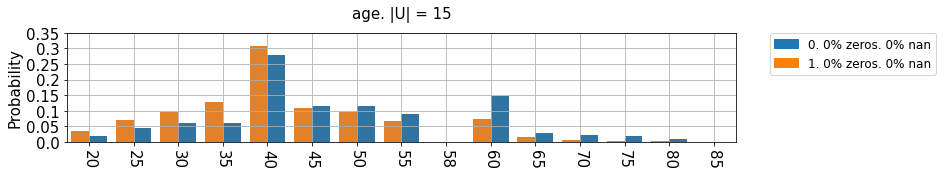

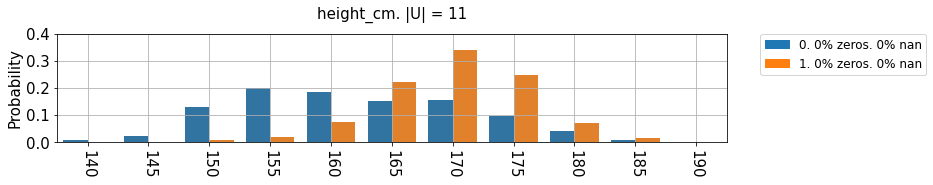

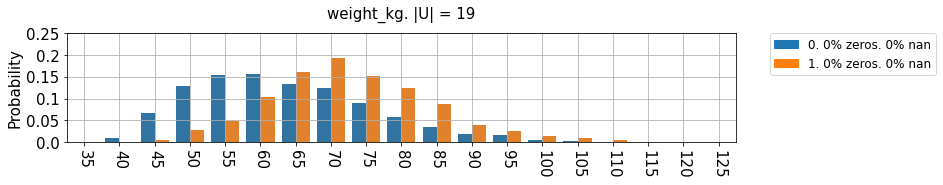

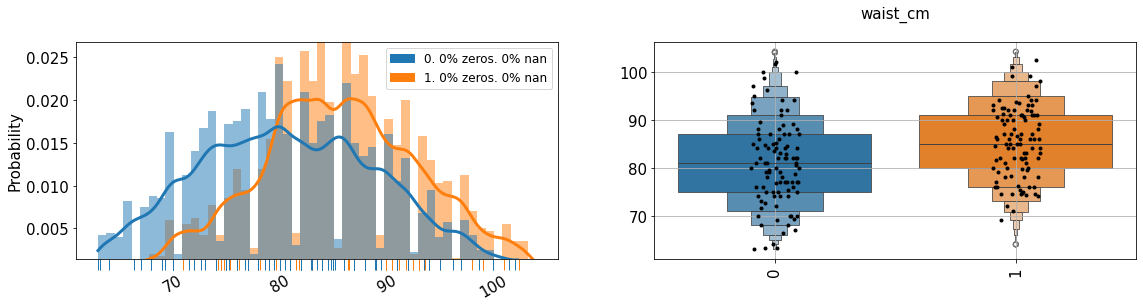

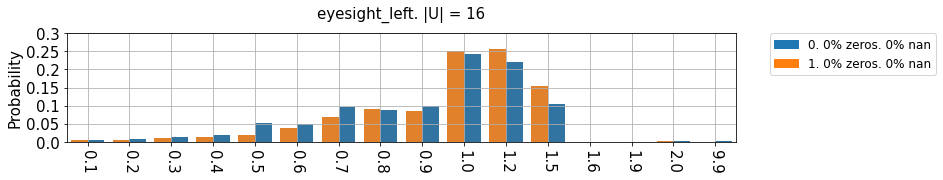

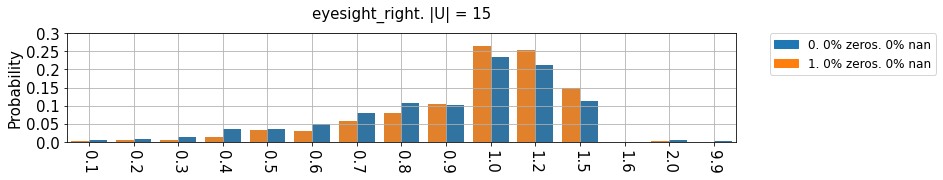

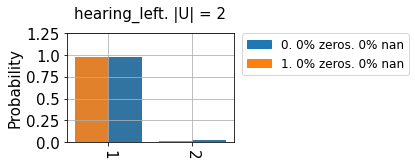

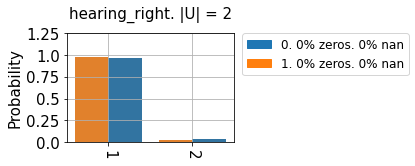

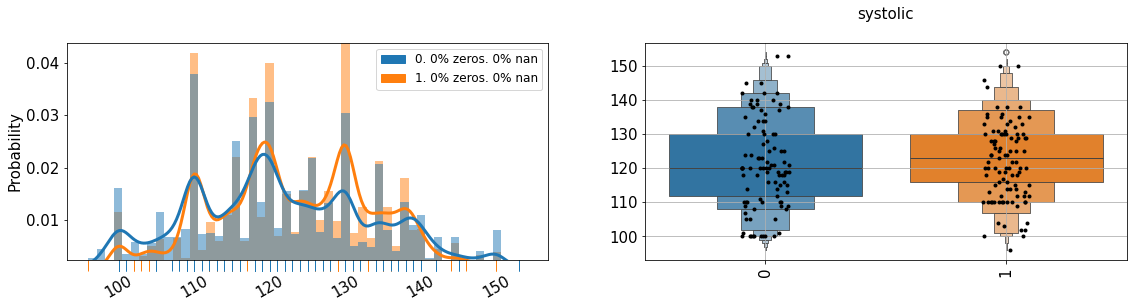

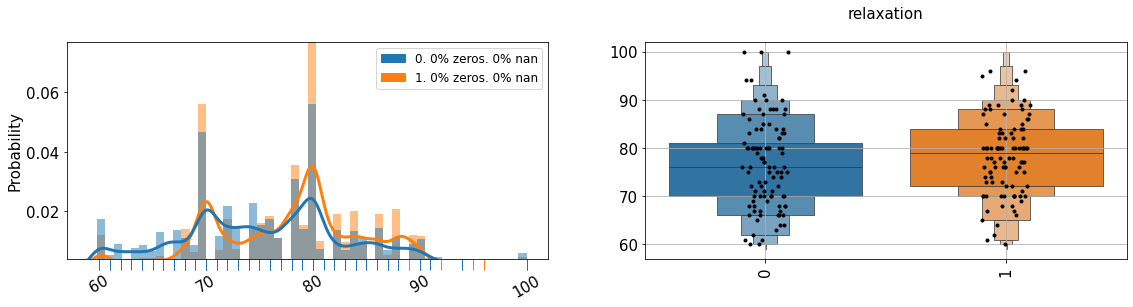

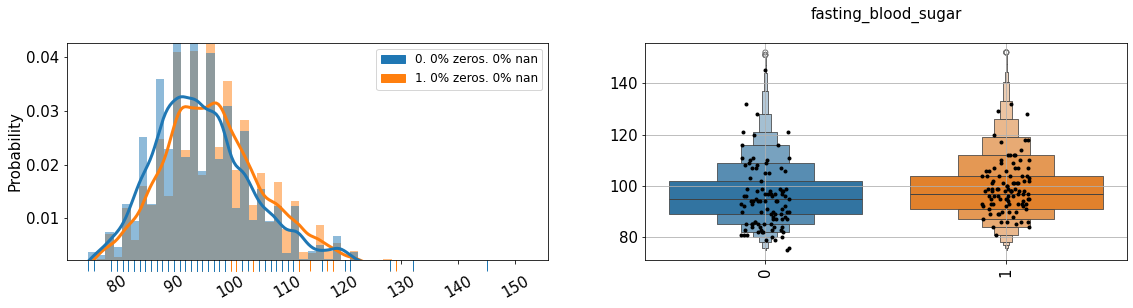

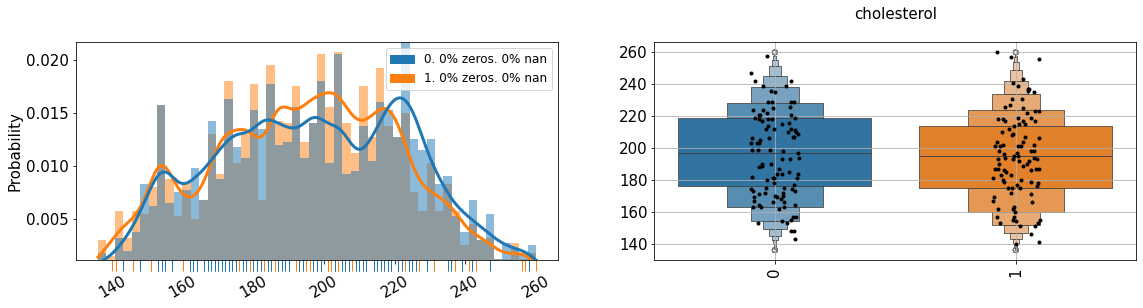

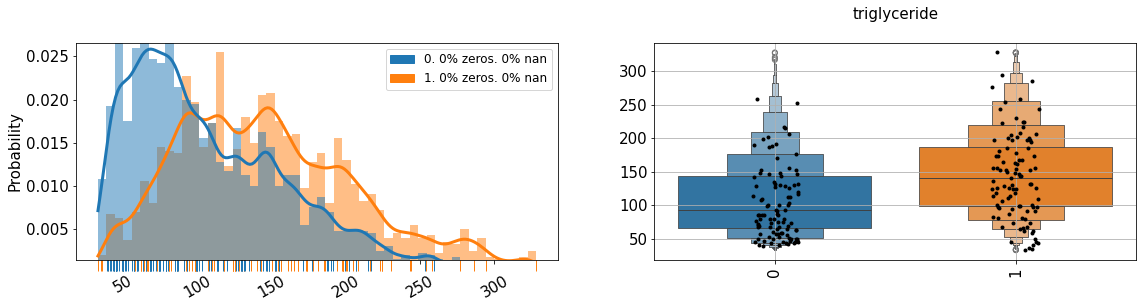

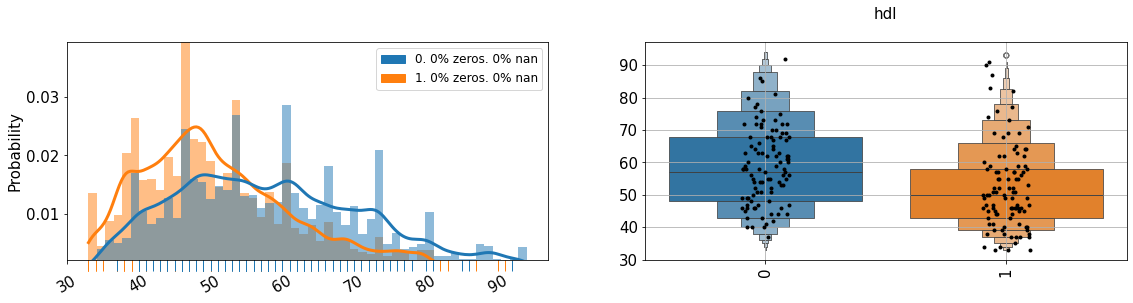

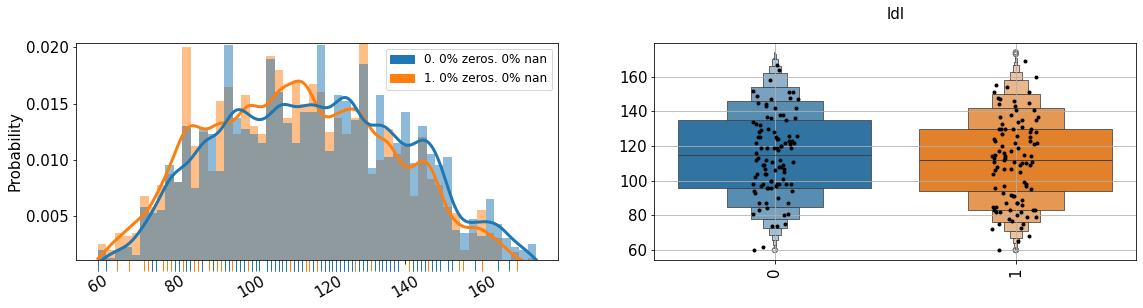

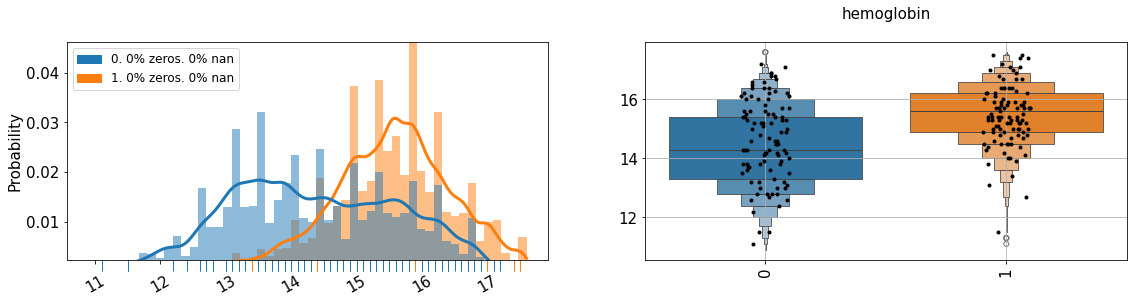

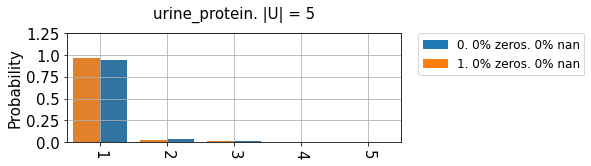

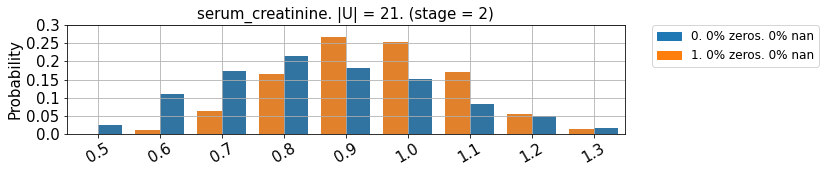

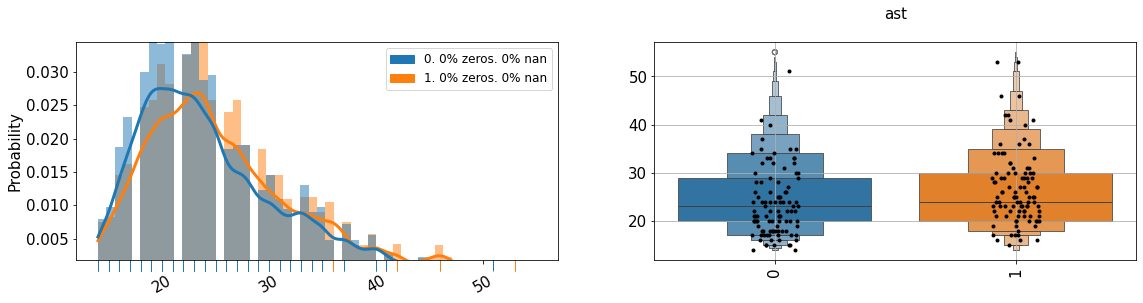

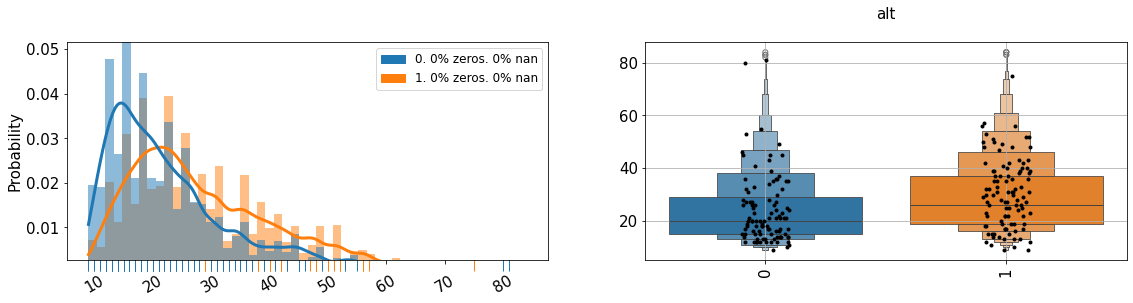

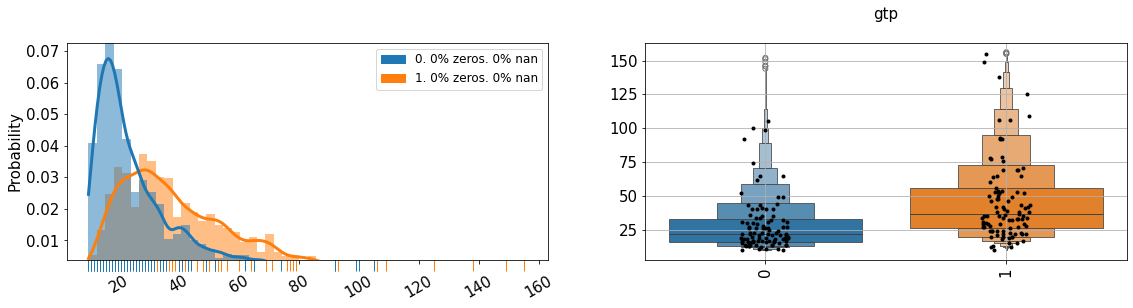

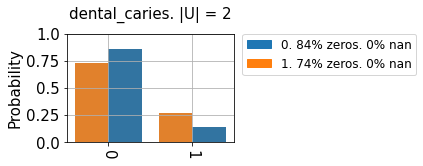

In [4]:
# НЕ ЗАПУСКАЙТЕ ЭТУ ЯЧЕЙКУ! У ВАС МОИ ФУНКЦИИ РАБОТАТЬ НЕ БУДУТ Используйте свои :)

from my_utils.plot import *

p = Plotter(tr, 'smoking', cols=tr.columns)

p.plot_density()

Ух ты, как интересно! Пожалуй, буду пока ориентироваться лишь на некоторые симпатичные признаки...

In [49]:
tr['new_log_gtp'] = np.log1p(tr.gtp)
tst['new_log_gtp'] = np.log1p(tst.gtp)

my_favorite_cols = ['age', 'height_cm', 'weight_kg', 'hemoglobin', 'new_log_gtp']

import plotly.express as px

fig = px.scatter_3d(tr, x='age', y='hemoglobin', z='new_log_gtp', color='smoking')
fig.update_traces(marker_size=2.5)
fig.show()

Какая-то каша, но видны некоторые закономерности в цветах и синий носик!

In [11]:
# Подготовим данные, чтобы рисовать эмбеддинги - весь трейн и немного теста, чтобы долго не ждать
#     и иметь возможность интерактивить
plot_cols = np.r_[my_favorite_cols, ['smoking']]
plot_data_tr = tr[plot_cols].copy()
plot_data_tst = tst[plot_cols].sample(1_000, random_state=911)
plot_data = pd.concat([plot_data_tr, plot_data_tst], axis=0, sort=False, ignore_index=True)

In [12]:
# Напишем dummy-helper-функцию

def plot_standard_embeddings(plot_data, features, return_results=False):
    '''
    рисует "какие-то" эмбеддинги с hue='smoking' на одних и тех же фичах features
    '''
    mapper_dict = {
        'tsne 2D perplexity=60 exaggeration=4': {
            'params': {
                'n_jobs': 8,
                'perplexity': 60,
                'verbose': False,
                'n_components': 2,
                'exaggeration': 4,
                'neighbors': 'pynndescent' # annoy - neighbors по умолчанию - почему-то виснет на .transform
            },
            'func': make_tsne,
        },
        'tsne 2D perplexity=60 exaggeration=4 dof=0.5': {
            'params': {
                'n_jobs': -1,
                'perplexity': 60,
                'verbose': False,
                'n_components': 2,
                'exaggeration': 4,
                'dof': 0.5,
                'neighbors': 'pynndescent'
            },
            'func': make_tsne,
        },
        'UMAP 2D n_neighbors=17': {
            'params': {
               'n_neighbors': 17,
               'min_dist': 0.1,
               'n_jobs': 8,
               'verbose': False,
               'n_components': 2
            },
            'func': make_umap,
        },
        'PCA 3D': {
            'params': {
               'n_components': 3
            },
            'func': make_pca,
        },
    }

    res = plot_dim_reduction(
        data=plot_data,
        mapper_dict=mapper_dict,
        default_features=features,
        default_hue_info=hue_info(field_name='smoking', is_categorical=True),
        row_height=450,
        return_results=return_results
    )
    return res

# И нарисуем наши первые эмбеддинги!
plot_standard_embeddings(plot_data, my_favorite_cols)

Loading BokehJS ...

100%|██████████| 4/4 [02:09<00:00, 32.35s/it]


    'data': [{'hovertemplate': 'smoking=1<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></…

Снова какая-то чушь! Кажется, нужно заскейлить признаки...

In [13]:
# Скейлим...

means = plot_data_tr[my_favorite_cols].mean(axis=0)
stds = plot_data_tr[my_favorite_cols].std(axis=0)

plot_data_tr.loc[:, my_favorite_cols] = (plot_data_tr.loc[:, my_favorite_cols] - means) / stds
plot_data_tst.loc[:, my_favorite_cols] = (plot_data_tst.loc[:, my_favorite_cols] - means) / stds
plot_data_scaled = pd.concat([plot_data_tr, plot_data_tst], axis=0, sort=False, ignore_index=True)

In [14]:
results = plot_standard_embeddings(plot_data_scaled, my_favorite_cols, return_results=True)

Loading BokehJS ...

100%|██████████| 4/4 [01:33<00:00, 23.38s/it]


    'data': [{'hovertemplate': 'smoking=1<br>x=%{x}<br>y=%{y}<br>z=%{z}<extra></…

Ух ты! Закономерности...


Решили так - левый кластер почти не курит, будем всем объектам из теста, которые попали туда, предсказывать 0, остальным - случайный класс :)

Для того чтобы понять, какие объекты теста попадают в этот кластер, нужно насадить тест на карту с помощью transform, а затем кластеризовать полученную тест-карту и посмотреть на результат...

In [15]:
results

{'tsne 2D perplexity=60 exaggeration=4': {'embedding': TSNEEmbedding([[ 1.44763165, -0.20005425],
                 [ 4.21566854, -1.46424838],
                 [-0.63337287,  1.2554884 ],
                 ...,
                 [-2.66260062, -2.10351146],
                 [-1.21360939,  2.2087952 ],
                 [ 4.42773035, -0.6904412 ]]),
  'mapper': None},
 'tsne 2D perplexity=60 exaggeration=4 dof=0.5': {'embedding': TSNEEmbedding([[ 3.87573742, -0.41609956],
                 [ 6.81713537, -0.32082567],
                 [ 0.49265839,  0.73735914],
                 ...,
                 [-8.10313608, -1.90096156],
                 [ 0.26447763,  1.35108939],
                 [ 6.73955596,  0.26539911]]),
  'mapper': None},
 'UMAP 2D n_neighbors=17': {'embedding': array([[ 9.84338  ,  4.5607424],
         [13.995821 ,  9.614105 ],
         [ 7.4581227,  4.9826016],
         ...,
         [ 3.8882556,  0.8738574],
         [ 3.559781 ,  6.0764093],
         [12.972264 ,  9.274874 

In [16]:
%%time
tsne_mapper_embedding = results['tsne 2D perplexity=60 exaggeration=4 dof=0.5']['embedding']

# Не делайте так, если у вас хватает памяти сделать копию!
tst.loc[:, my_favorite_cols] = (tst.loc[:, my_favorite_cols] - means) / stds

tsne_test_embedding = tsne_mapper_embedding.transform(tst[my_favorite_cols], perplexity=60)

CPU times: total: 7min 17s
Wall time: 1min 2s


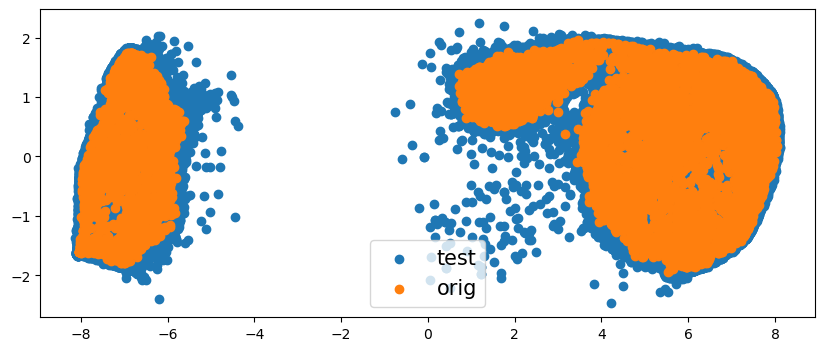

In [17]:
import matplotlib.pyplot as plt

plt.scatter(x=tsne_test_embedding[:, 0], y=tsne_test_embedding[:, 1], label='test')
plt.scatter(x=tsne_mapper_embedding[:, 0], y=tsne_mapper_embedding[:, 1], label='orig')
plt.legend(fontsize=15)
plt.gcf().set_size_inches(10, 4)

Пойдет для нашего dummy-пайплайна, главное - чтобы большие кластеры были различимы. Но в идеале - поиграться с аргументами transform. Теперь кластеризуем большие куски.

In [18]:
%%time
import fast_hdbscan # немного долго импортируется в первый раз

hdbscan = fast_hdbscan.HDBSCAN(min_samples=10, min_cluster_size=50)
clusters = hdbscan.fit_predict(tsne_test_embedding)

CPU times: total: 28.2 s
Wall time: 24.3 s


<Axes: >

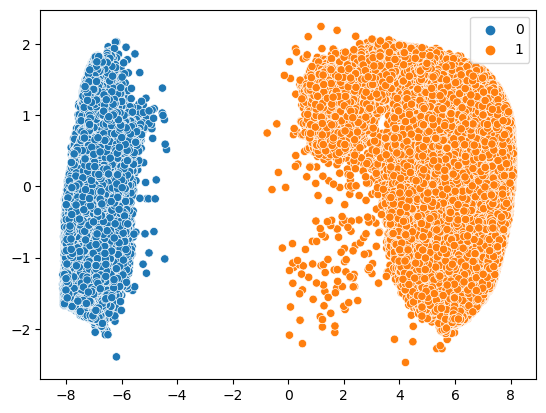

In [19]:
import seaborn as sns

sns.scatterplot(x=tsne_test_embedding[:, 0], y=tsne_test_embedding[:, 1], hue=clusters)

То что надо! Значит, кластеру 0 присваиваем smoking=0, кластеру 1 - рандомное значение.

In [20]:
y_pred = tst.smoking
y_pred.loc[clusters == 0] = 0

n_other = (clusters != 0).sum()
y_pred.loc[clusters != 0] = np.random.choice([0, 1], size=n_other)

y_pred.value_counts()

C:\Users\alexe\AppData\Local\Temp\ipykernel_20120\2679163917.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alexe\AppData\Local\Temp\ipykernel_20120\2679163917.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0    99220
1    50036
Name: smoking, dtype: int64

In [21]:
res = pd.DataFrame({'id': np.arange(tst.shape[0]), 'smoking': y_pred})
res

id  smoking
0            0        1
1            1        1
2            2        1
3            3        1
4            4        1
...        ...      ...
149251  149251        0
149252  149252        0
149253  149253        0
149254  149254        0
149255  149255        0

[149256 rows x 2 columns]

In [22]:
res.to_csv('data/dummy_sub.csv', index=False)

Я оставлю в этом ноутбуке dummy, потому что я отправлял его на контест первым и далее сравнивался уже с ним. Также я брал отсюда куски кода.

Основной пайплайн и рассуждения представлены в research ноутбуке, но здесь я покажу как я получил 2 своих наивысших скора: первый раз когда просто побил бейзлайн, а второй когда улучшил результат на 0.15

In [50]:
tr.columns

Index(['age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right', 'hearing_left', 'hearing_right', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'urine_protein', 'serum_creatinine', 'ast',
       'alt', 'gtp', 'dental_caries', 'smoking', 'new_log_gtp'],
      dtype='object')

Наилучший результат получился у нас с помощью логистической регрессии, поэтому думаю, что имеет смысл подровнять некоторые признаки и убрать парочку явно одинаковых. Пойдем по порядку:
1) 'age', 'height_cm', 'weight_kg', 'waist_cm', 'eyesight_left',
       'eyesight_right' - отличаются, можем брать их для логистической регрессии.
2) 'hearing_left', 'hearing_right' - практически идентичны, то есть можем убрать эти признаки.
3) 'systolic', 'relaxation' - отличаются, но данные распределены горкообразно, по идее повлиять сильно не должно.
4) 'fasting_blood_sugar' - видна закономерность о том, что там, где значения поменьше больше некурящих и наоборот, то есть можем брать признак.
5) 'cholesterol' - можно взять, но различия невелики.
6) 'triglyceride' - ОЧЕНЬ сильно видна зависимость, но также думаю имеет смысл логарифмировать этот признак.
7) 'hdl' - видна зависимость, но несильная, также можно логарифмировать, но пока не буду.
8) 'ldl' - зависимость очень невелика на первый взгляд, но пока что признак берем.
9) 'hemoglobin' - Очень сильно видна зависимость - берем.
10) 'urine_protein' - почти одинаково, можем не брать.
11) 'serum_creatinine' - берем, различия наблюдаются (у некурильщиков в среднем поменьше)
12) 'ast', 'alt' - различия видны, очень хорошие признаки, просматривается логнормальное распределение - логарифмируем и берем.
13) 'gtp' - тоже распределено логнормально, берем и логарифмируем.
14) 'dental_caries' - видны различия, берем.

In [51]:
df_tr = tr.drop(columns = ['hearing_left', 'hearing_right', 'triglyceride', 'urine_protein', 'ast', 'alt', 'smoking', 'gtp'])
df_tst = tst.drop(columns = ['hearing_left', 'hearing_right', 'triglyceride', 'urine_protein', 'ast', 'alt', 'smoking', 'gtp'])

df_tr['new_log_triglyceride'] = np.log1p(tr.triglyceride)
df_tst['new_log_triglyceride'] = np.log1p(tst.triglyceride)

df_tr['new_log_ast'] = np.log1p(tr.ast)
df_tst['new_log_ast'] = np.log1p(tst.ast)

df_tr['new_log_alt'] = np.log1p(tr.alt)
df_tst['new_log_alt'] = np.log1p(tst.alt)

print(df_tr.shape)
print(df_tst.shape)


(10000, 19)
(149256, 19)


In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающий и тестовый наборы
X_train = df_tr
y_train = tr.smoking
X_test = df_tst

# Нормализуем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализируем и обучаем модель логистической регрессии
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Делаем предсказания на тестовом наборе
predictions = model.predict(X_test_scaled)

print(predictions)

[1 1 1 ... 0 1 0]


In [55]:
res = pd.DataFrame({'id': np.arange(tst.shape[0]), 'smoking': predictions})
res

id  smoking
0            0        1
1            1        1
2            2        1
3            3        1
4            4        0
...        ...      ...
149251  149251        1
149252  149252        0
149253  149253        0
149254  149254        1
149255  149255        0

[149256 rows x 2 columns]

Таким образом, более подробно изучив данные и немного их видоизменив и удалив несколько не играющих роли признаков, я запустил логистическую регрессию и получил скор 0.508

Далее я попробовал knn с количеством соседей 250 и поставил новый рекорд в 0.521

In [56]:
import faiss

def build_flat_l2(build_data, dim):
    index = faiss.IndexFlatL2(dim)
    index.train(build_data)
    index.add(build_data)
    return index

def search_flat(index, query_data, k):
    distances, labels = index.search(query_data, k)
    return distances, labels

In [57]:
dim = df_tr.shape[1]
k_0 = 250

flat_index = build_flat_l2(X_train_scaled, dim)
flat_distances, flat_labels = search_flat(flat_index, X_test_scaled, k_0)

In [58]:
flat_labels

array([[ 135, 2057, 9563, ..., 1336, 4844, 8097],
       [1344,   88, 9238, ..., 7896, 5068, 1729],
       [4583,  492, 5727, ..., 8478, 6824, 7021],
       ...,
       [4652, 8943, 6757, ..., 4913, 5731, 1646],
       [1613, 7393, 3314, ..., 8818,  609,  231],
       [3315, 1587, 7285, ...,   37, 3937, 6937]], dtype=int64)

In [59]:
result = tr.smoking[flat_labels.flatten()].to_numpy()
result = result.reshape(flat_labels.shape[0], flat_labels.shape[1])

In [60]:
prediction = result.mean(axis = 1)
prediction = list(map(int, np.round(prediction, decimals = 0)))
prediction = pd.Series(prediction)
prediction.value_counts()

1    80333
0    68923
dtype: int64

In [61]:
res = pd.DataFrame({'id': np.arange(tst.shape[0]), 'smoking': prediction})
res

id  smoking
0            0        1
1            1        0
2            2        1
3            3        1
4            4        0
...        ...      ...
149251  149251        1
149252  149252        0
149253  149253        0
149254  149254        1
149255  149255        0

[149256 rows x 2 columns]

Итак, я получил максимальный скор 0.521, использовав метод ближайших соседей, построив index на train выборке.